In [1]:
import numpy as np
from scipy import interpolate, linalg, optimize


# Numbers here are hardcoded for the JLA compilation
# The interpolation.npy is only for JLA redshifts

c = 299792.458 # km/s
H0 = 70 #(km/s) / Mpc

N=740 ; # Number of SNe

# Spline interpolation of luminosity distance
# Interpolation.npy is a table calculated in Mathematica
# The grid size can be seen from here: .01 between calculated points (in OM-OL space).
# Only calculated for OM in [0,1.5], OL in [-.5,1.5]
print 'loading Interpolation'
interp = np.load( 'Interpolation.npy' )
print 'splining'
tempInt = [] ;
for i in range(N):
	tempInt.append(interpolate.RectBivariateSpline( np.arange(0,1.51,.01), np.arange(-.50,1.51,.01) , interp[i]))	

def dL( OM, OL ): # Returns in same order as always - c/H0 multiplied on after, in mu
	return np.hstack( [tempdL(OM,OL) for tempdL in tempInt] );
def MU( OM, OL ):
	return 5*np.log10( c/H0 * dL(OM,OL) ) + 25

#Import JLA data
#cols are z,m,x,c,cluster mass, survey
print 'loading jla.npy'
Z = np.load( 'JLA.npy' ) ;

#### FULL LIKELIHOOD ####
print 'loading full likelihood'
COVd = np.load( 'covmat/stat.npy' ) # Constructing data covariance matrix w/ sys.
# sigmaz and sigmalens are constructed as described in the JLA paper
# all others are taken from their .tar and converted to python format
for i in [ "cal", "model", "bias", "dust", "pecvel", "sigmaz", "sigmalens", "nonia" ]:
#Notice the lack of "host" covariances - we don't include the mass-step correction.
	COVd += np.load( 'covmat/'+i+'.npy' ); print 'loaded covmat/'+i+'.npy'

def COV( A , B , VM, VX, VC , RV=0): # Total covariance matrix
	block3 = np.array( [[VM + VX*A**2 + VC*B**2,    -VX*A, VC*B],
												 [-VX*A , VX, 0],
												 [ VC*B ,  0, VC]] )
	ATCOVlA = linalg.block_diag( *[ block3 for i in range(N) ] ) ;
	
	if RV==0:
		return np.array( COVd + ATCOVlA );
	elif RV==1:
		return np.array( COVd );
	elif RV==2:
		return np.array( ATCOVlA );

def RES( OM, OL , A , B , M0, X0, C0 ): #Total residual, \hat Z - Y_0*A
	Y0A = np.array([ M0-A*X0+B*C0, X0, C0 ]) 
	mu = MU(OM, OL)[0] ;
	return np.hstack( [ (Z[i,1:4] -np.array([mu[i],0,0]) - Y0A ) for i in range(N) ] )  


def m2loglike(pars , RV = 0):
	if RV != 0 and RV != 1 and RV != 2:
		raise ValueError('Inappropriate RV value')
	else:
		cov = COV( *[ pars[i] for i in [2,5,9,4,7] ] )
		try:
			chol_fac = linalg.cho_factor(cov, overwrite_a = True, lower = True ) 
		except ValueError: # If contains infinity
			return 13995*10.**20
		except:# If not positive definite
			return 13993*10.**20 
		res = RES( *[ pars[i] for i in [0,1,2,5,8,3,6] ] )

		#Dont throw away the logPI part.
		part_log = 3*N*np.log(2*np.pi) + np.sum( np.log( np.diag( chol_fac[0] ) ) ) * 2
		part_exp = np.dot( res, linalg.cho_solve( chol_fac, res) )

		if pars[0]<0 or pars[0]>1.5 or pars[1]<-.50 or pars[1]>1.5 \
			or pars[4]<0 or pars[7]<0 or pars[9]<0:
			part_exp += 100* np.sum(np.array([ _**2 for _ in pars ]))
			# if outside valid region, give penalty
        if RV==0:
            #print 'rv0'
            m2loglike = part_log + part_exp
            #print 'inside',part_log, part_exp,m2loglike
            if np.isnan(m2loglike):
                print 'isnan'
                return 13995*10.**20
            elif np.isinf(m2loglike):
                print 'isinf'
                return 13995*10.**20
            else:
                return m2loglike 
        elif RV==1: 
            print 'rv1'
            return part_exp 
        elif RV==2:
            print 'rv2'
            return part_log 

# Constraint fucntions for fits (constraint is func == 0)

def m2CONSflat( pars ):
	return pars[0] + pars[1] - 1

def m2CONSempt( pars ):
	return pars[0]**2 + pars[1]**2


def m2CONSzm( pars ):
	return pars[0]**2

def m2CONSEdS( pars ):
	return (pars[0]-1)**2 + pars[1]**2

def m2CONSacc( pars ):
	return pars[0]/2. - pars[1]

#### CONSTRAINED CHI2 ####

def COV_C( A , B , VM ):
	block1 = np.array( [1 , A , -B] ) ;
	AJLA = linalg.block_diag( *[ block1 for i in range(N) ] );
	return np.dot( AJLA, np.dot( COVd, AJLA.transpose() ) ) + np.eye(N) * VM;

def RES_C( OM, OL, A ,B , M0 ):
	mu = MU(OM,OL)[0] ;
	return Z[:,1] - M0 + A * Z[:,2] - B * Z[:,3] - mu

# INPUT HERE IS REDUCED: pars = [ om, ol, a, b, m0] , VM seperate

def chi2_C( pars, VM ):
	if pars[0]<0 or pars[0]>1.5 or pars[1]<-.50 or pars[1]>1.5 \
		or VM<0:
		return 14994*10.**20
	cov = COV_C( pars[2], pars[3] , VM )
	chol_fac = linalg.cho_factor( cov, overwrite_a = True, lower = True )
	
	res = RES_C( *pars )
	
	part_exp = np.dot( res , linalg.cho_solve( chol_fac, res) )
	return part_exp


bounds = ( (0,1.5),(-0.5,1.5),
			(None,None),(None,None),(0,None),
			(None,None),(None,None),(0,None),
			(None,None),(0,None) )

# Results already found

pre_found_best = np.array([  3.40658319e-01,   5.68558786e-01,   1.34469382e-01,
							 3.84466029e-02,   8.67848219e-01,   3.05861386e+00,
							 -1.59939791e-02,   5.04364259e-03,  -1.90515806e+01,
					          1.17007078e-02])

pre_found_flat = np.array([  3.76006396e-01,   6.23993604e-01,   1.34605635e-01,
							 3.88748714e-02,   8.67710982e-01,   3.05973830e+00,
							 -1.60202529e-02,   5.04243167e-03,  -1.90547810e+01,
					          1.16957181e-02])

pre_found_empty = np.array([  7.63122262e-09,   3.20273284e-08,   1.32775473e-01,
							 3.35901703e-02,   8.68743215e-01,   3.05069685e+00,
							 -1.47499271e-02,   5.05601201e-03,  -1.90138708e+01,
					          1.19714588e-02])

pre_found_ZM = np.array([  9.86339832e-11,   9.39491731e-02,   1.33690024e-01,
							 3.58225394e-02,   8.69494545e-01,   3.05946289e+00,
							 -1.68347116e-02,   5.07400516e-03,  -1.90319985e+01,
					          1.18656604e-02])

pre_found_EdS = np.array([  9.99999985e-01,   4.19831315e-09,   1.23244919e-01,
						 1.43884399e-02,   8.59506526e-01,   3.03882366e+00,
						  9.26889810e-03,   5.11253864e-03,  -1.88388322e+01,
						   1.55137148e-02])

pre_found_noacc = np.array([  6.84438318e-02,   3.42219159e-02,   1.32357422e-01,
							 3.26703396e-02,   8.67993385e-01,   3.04503841e+00,
							 -1.33181840e-02,   5.04076126e-03,  -1.90062602e+01,
					          1.19991540e-02])


loading Interpolation
splining
loading jla.npy
loading full likelihood
loaded covmat/cal.npy
loaded covmat/model.npy
loaded covmat/bias.npy
loaded covmat/dust.npy
loaded covmat/pecvel.npy
loaded covmat/sigmaz.npy
loaded covmat/sigmalens.npy
loaded covmat/nonia.npy


In [4]:
%matplotlib inline
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

In [5]:
import mcmc as m

mcmc_obj = m.mh(m2loglike,[0])

param_step_stds = np.sqrt(abs(pre_found_best))/400.
mcmc_obj.run_d_mc(pre_found_best,param_step_stds,numsteps=2000,burn_in=10)

p, p_uncertainty, chains, accepted_fraction, loglike_history = mcmc_obj.get_params()

## chains = size(numsteps,length(p0))


Total Time: 278.201849937
Num Iterations: 1000
Accepted Percentage: 0.443556443556
Seconds per iteration: 0.278201849937
Total Time: 536.726217031
Num Iterations: 2000
Accepted Percentage: 0.461269365317
Seconds per iteration: 0.268363108516
Total Time: 536.726492882
Num Iterations: 2000
Accepted Percentage: 0.461269365317
Seconds per iteration: 0.268363246441


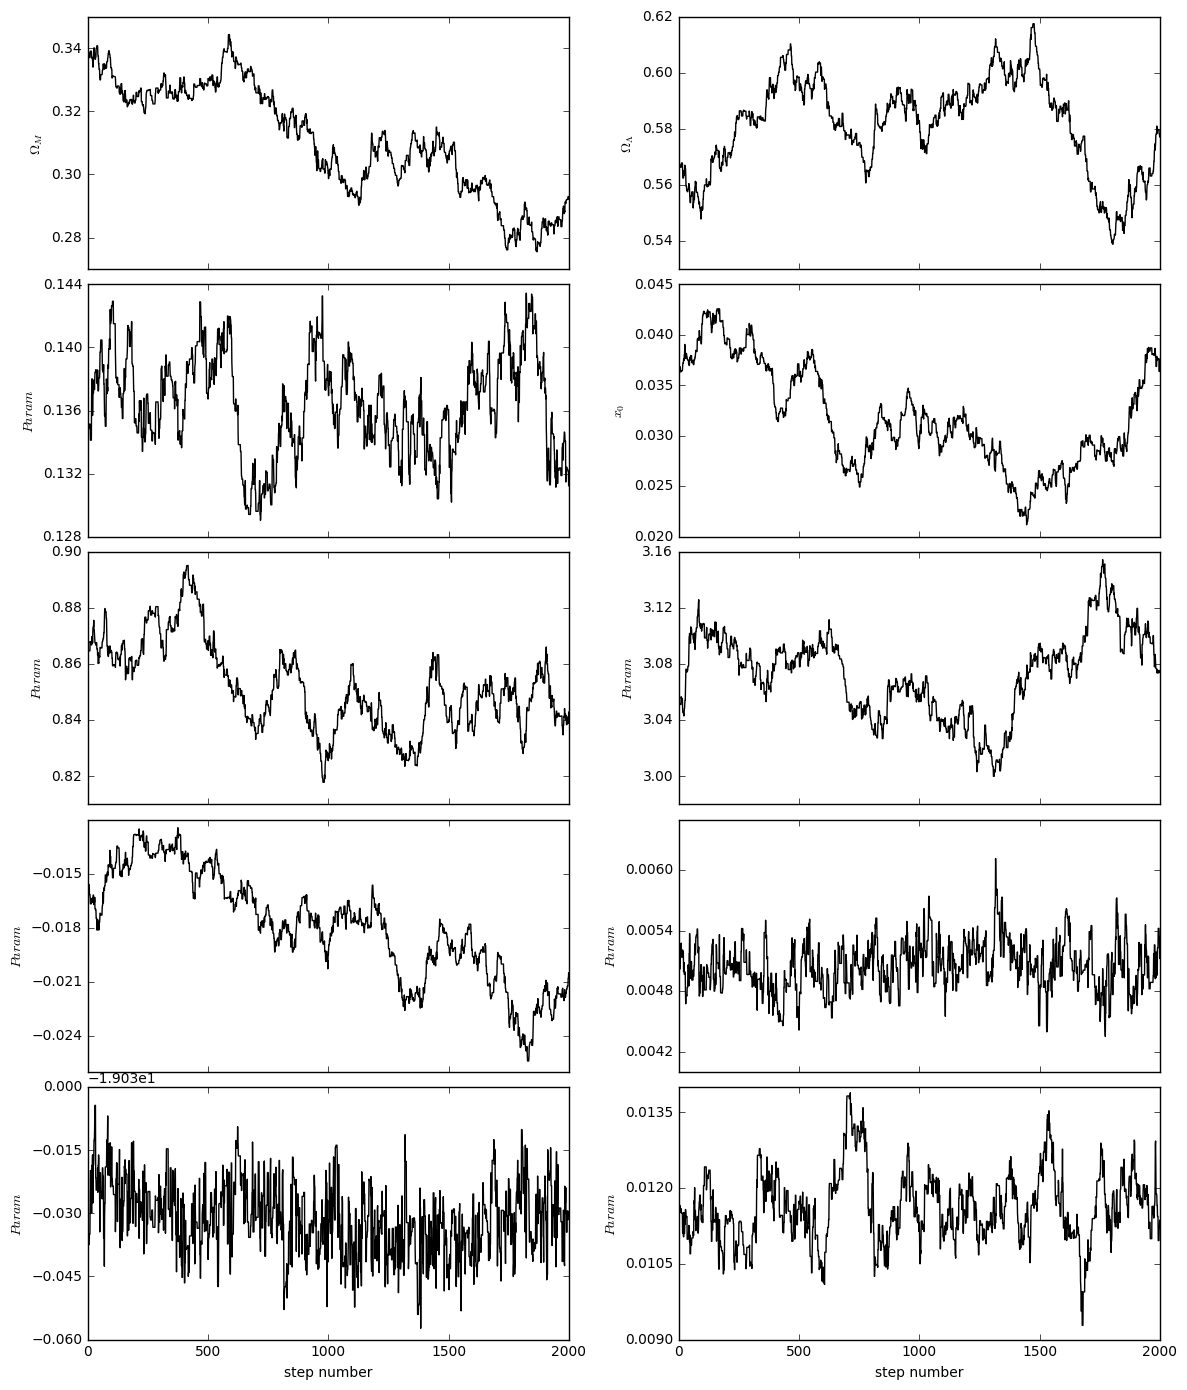

In [7]:
labels = ["$\Omega_M$","$\Omega_{\Lambda}$","$Param$","$x_0$","$Param$","$Param$","$Param$","$Param$","$Param$","$Param$"]
fig, axesx = pl.subplots(5,2, sharex=True, figsize=(12, 14))
axes = axesx.ravel()
for i in range(len(chains[0,:])):
    axes[i].plot(chains[:, i], color="k")
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(labels[i])

axes[-2].set_xlabel("step number")
axes[-1].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)

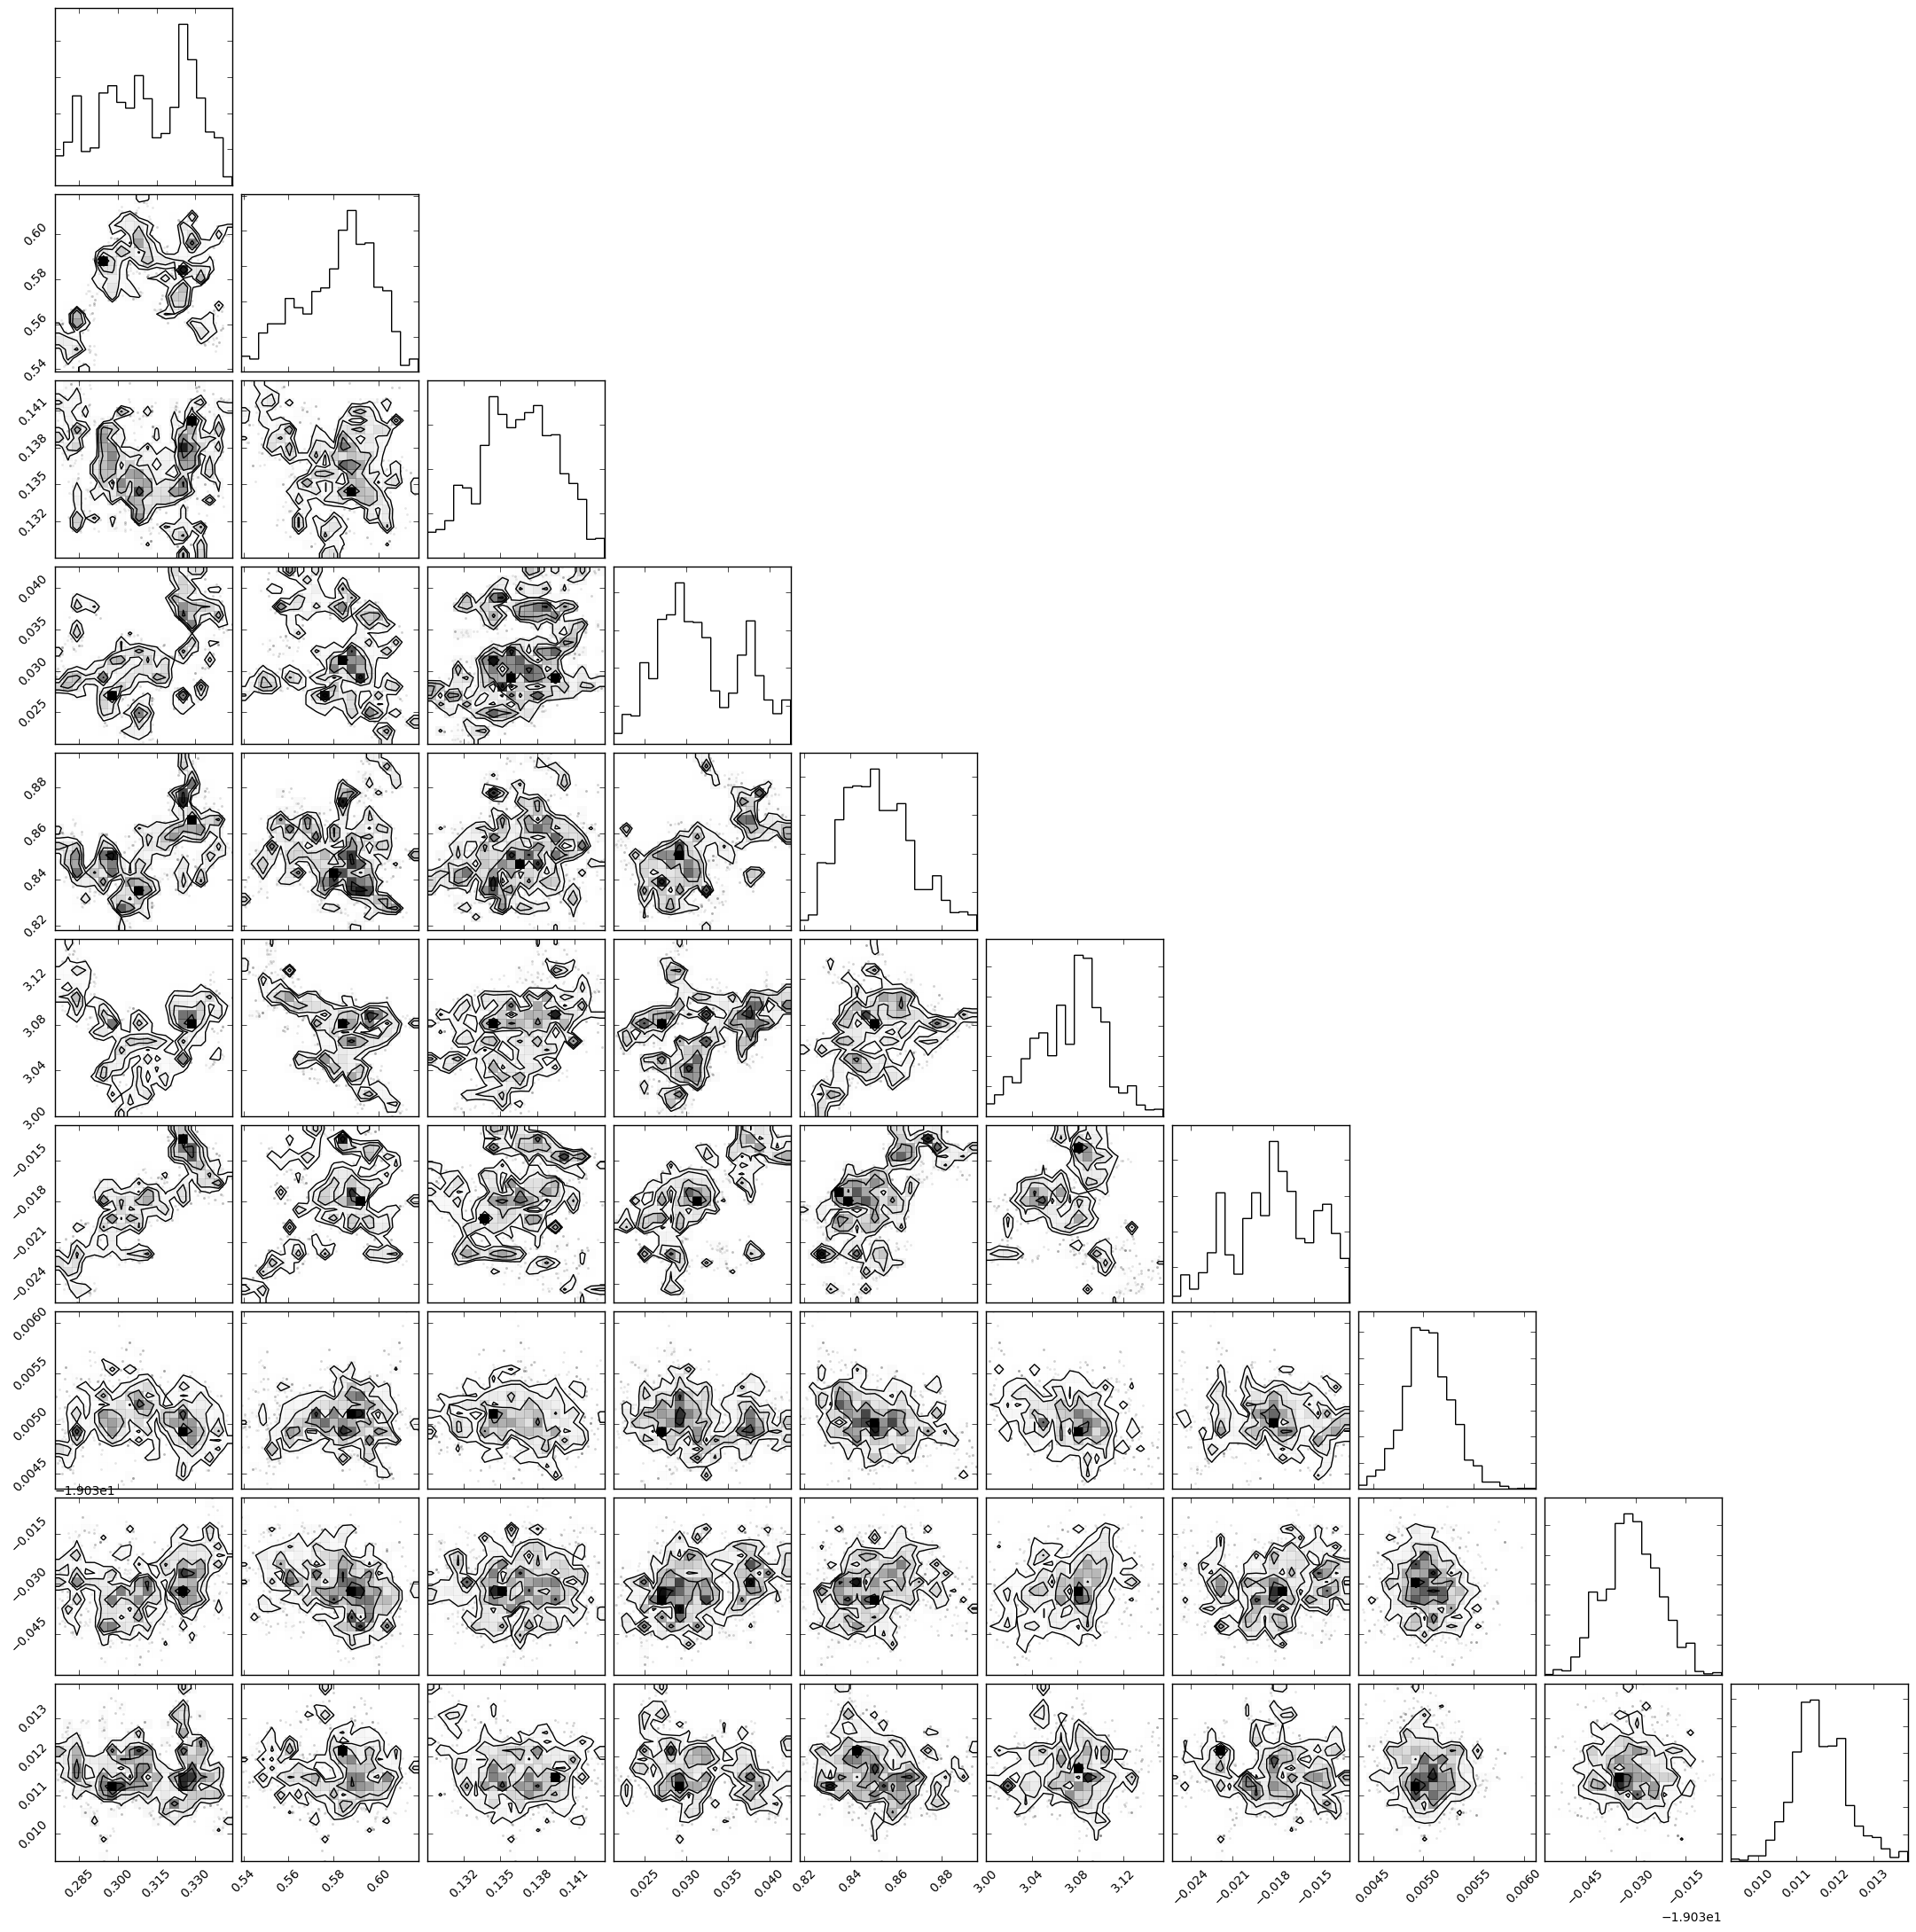

In [8]:
import corner
fig = corner.corner(chains)